## Adding a subset of COCO people data

In [1]:
import glob
import json

import cv2
import matplotlib.pyplot as plt
import numpy as np
from luxonis_ml.data import LuxonisDataset, LuxonisLoader
from luxonis_ml.enums import LabelType
from tqdm import tqdm

In [2]:
# Delete dataset if exists

dataset_name = "coco_test"
if LuxonisDataset.exists(dataset_name):
    dataset = LuxonisDataset(dataset_name)
    dataset.delete_dataset()

### Download and extract data

In [3]:
! pip install gdown
! gdown 1XlvFK7aRmt8op6-hHkWVKIJQeDtOwoRT -O ../data/COCO_people_subset.zip
! unzip ../data/COCO_people_subset.zip -d ../data/

Downloading...
From: https://drive.google.com/uc?id=1XlvFK7aRmt8op6-hHkWVKIJQeDtOwoRT
To: /home/martin/Work/luxonis-ml/data/COCO_people_subset.zip
100%|██████████████████████████████████████| 7.78M/7.78M [00:03<00:00, 2.45MB/s]
Archive:  ../data/COCO_people_subset.zip
  inflating: ../data/person_keypoints_val2017.json  
   creating: ../data/person_val2017_subset/
  inflating: ../data/person_val2017_subset/000000001490.jpg  
  inflating: ../data/person_val2017_subset/000000003934.jpg  
  inflating: ../data/person_val2017_subset/000000005060.jpg  
  inflating: ../data/person_val2017_subset/000000003255.jpg  
  inflating: ../data/person_val2017_subset/000000001761.jpg  
  inflating: ../data/person_val2017_subset/000000001000.jpg  
  inflating: ../data/person_val2017_subset/000000002431.jpg  
  inflating: ../data/person_val2017_subset/000000002006.jpg  
  inflating: ../data/person_val2017_subset/000000002261.jpg  
  inflating: ../data/person_val2017_subset/000000004395.jpg  
  inflating: .

### Convert from COCO people subset example

`LuxonisDataset` will expect a generator that yields data in the following format:
```
- file [str] : path to file on local disk or object storage
- class [str]: string specifying the class name or label name
- type [str] : the type of label or annotation
- value [Union[str, list, int, float, bool]]: the actual annotation value
    For here are the expected structures for `value`.
    The function will check to ensure `value` matches this for each annotation type

    value (classification) [bool] : Marks whether the class is present or not
        (e.g. True/False)
    value (box) [List[float]] : the normalized (0-1) x, y, w, and h of a bounding box
        (e.g. [0.5, 0.4, 0.1, 0.2])
    value (polyline) [List[List[float]]] : an ordered list of [x, y] polyline points
        (e.g. [[0.2, 0.3], [0.4, 0.5], ...])
    value (keypoints) [List[List[float]]] : an ordered list of [x, y, visibility] keypoints for a keypoint skeleton instance
        (e.g. [[0.2, 0.3, 2], [0.4, 0.5, 2], ...])
```

In [4]:
# # create some artificial splits
# splits = ['train' for _ in range(20)] + ['val' for _ in range(10)]

def COCO_people_subset_generator():

    # find image paths and load COCO annotations
    img_dir = '../data/person_val2017_subset'
    annot_file = '../data/person_keypoints_val2017.json'
    # get paths to images sorted by number
    im_paths = glob.glob(img_dir+'/*.jpg')
    nums = np.array([int(path.split('/')[-1].split('.')[0]) for path in im_paths])
    idxs = np.argsort(nums)
    im_paths = list(np.array(im_paths)[idxs])
    # load
    with open(annot_file) as file:
        data = json.load(file)
    imgs = data['images']
    anns = data['annotations']

    for i, path in tqdm(enumerate(im_paths)):
        # find annotations matching the COCO image
        gran = path.split('/')[-1]
        img = [img for img in imgs if img['file_name']==gran][0]
        img_id = img['id']
        img_anns = [ann for ann in anns if ann['image_id'] == img_id]

        # load the image
        im = cv2.imread(path)
        height, width, _ = im.shape

        if len(img_anns):
            yield {
                "file": path,
                "class": "person",
                "type": "classification",
                "value": True
            }

        for ann in img_anns:
            # COCO-specific conversion for segmentation
            seg = ann['segmentation']
            if isinstance(seg, list):
                poly = []
                for s in seg:
                    poly_arr = np.array(s).reshape(-1,2)
                    poly += [[poly_arr[i,0]/width, poly_arr[i,1]/height] for i in range(len(poly_arr))]
                yield {
                    "file": path,
                    "class": "person",
                    "type": "polyline",
                    "value": poly
                }

            # COCO-specific conversion for bounding boxes
            x, y, w, h = ann['bbox']
            yield {
                "file": path,
                "class": "person",
                "type": "box",
                "value": [x/width, y/height, w/width, h/height]
            }

            # COCO-specific conversion for keypoints
            kps = np.array(ann['keypoints']).reshape(-1, 3)
            keypoint = []
            for kp in kps:
                keypoint.append([float(kp[0]/width), float(kp[1]/height), int(kp[2])])
            yield {
                "file": path,
                "class": "person",
                "type": "keypoints",
                "value": keypoint
            }

In [5]:
dataset = LuxonisDataset(dataset_name)
dataset.set_classes(["person"])

annot_file = '../data/person_keypoints_val2017.json'
with open(annot_file) as file:
    data = json.load(file)
dataset.set_skeletons({
    "person": {
        "labels": data["categories"][0]['keypoints'],
        "edges": (np.array(data["categories"][0]["skeleton"])-1).tolist()
    }
})
dataset.add(COCO_people_subset_generator)

30it [00:00, 205.90it/s]


Generating UUIDs...
Took 0.01261138916015625 seconds
Saving annotations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:00<00:00, 38298.55it/s]

Took 0.014262199401855469 seconds


### Define Splits

In [6]:
# without providing manual splits, this will randomly split the data
dataset.make_splits()

### Test Loader

Sample classification tensor
[1.]

Sample boxes tensor
[[0.         0.01685937 0.06797917 0.091      0.3528125 ]
 [0.         0.35225    0.53258333 0.198875   0.46741667]
 [0.         0.12070312 0.5095     0.17703125 0.490125  ]
 [0.         0.0641875  0.19933333 0.16723437 0.78827083]
 [0.         0.18629688 0.16966667 0.10821875 0.39202083]
 [0.         0.07939063 0.12197917 0.1323125  0.1749375 ]
 [0.         0.26748437 0.06470833 0.12559375 0.32183333]
 [0.         0.46409375 0.1044375  0.09125    0.18172917]
 [0.         0.33039062 0.1841875  0.19323438 0.40210417]
 [0.         0.5545     0.19102083 0.25448437 0.78875   ]
 [0.         0.67929688 0.08527083 0.11071875 0.24933333]
 [0.         0.66404688 0.0471875  0.06909375 0.1483125 ]
 [0.         0.3251875  0.12770833 0.13967188 0.30979167]
 [0.         0.8171875  0.05416667 0.18125    0.6       ]]

Sample segmentation tensor
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0

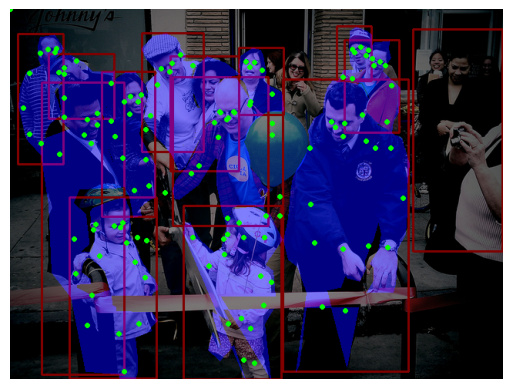

In [7]:
loader = LuxonisLoader(dataset, view="train")
for image, ann in loader:
    cls = ann[LabelType.CLASSIFICATION]
    box = ann[LabelType.BOUNDINGBOX]
    seg = ann[LabelType.SEGMENTATION]
    kps = ann[LabelType.KEYPOINT]

    print("Sample classification tensor")
    print(cls)
    print()

    print("Sample boxes tensor")
    print(box)
    print()

    print("Sample segmentation tensor")
    print(seg)
    print()

    print("Sample keypoints tensor")
    print(kps)
    print()

    h, w, _ = image.shape
    for b in box:
        cv2.rectangle(image, (int(b[1]*w),int(b[2]*h)), (int(b[1]*w+b[3]*w),int(b[2]*h+b[4]*h)), (255,0,0), 2)
    mask_viz = np.zeros((h,w,3)).astype(np.uint8)
    for mask in seg:
        mask_viz[mask==1, 2] = 255
    image = cv2.addWeighted(image, 0.5, mask_viz, 0.5, 0)

    for kp in kps:
        kp = kp[1:].reshape(-1,3)
        for k in kp:
            cv2.circle(image, (int(k[0]*w),int(k[1]*h)), 2, (0,255,0), 2)

    plt.imshow(image)
    plt.axis('off')  # Optional: Hide axis
    plt.show()
    break